In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lwhf.ml_logic.backtesting import backtesting

as_of_date = '2024-05-27'

port_return, weekly_returns, cleaned_weigths = backtesting(as_of_date, 3, 'W', 'alpaca_stock_prices')

KeyboardInterrupt: 

In [55]:
from lwhf.ml_logic.data_BQ import get_all_data, get_data
import datetime as DT

as_of_date = '2024-05-27'
n_periods = 3
timestep_data = 'W'
as_of = DT.datetime.strptime(as_of_date, '%Y-%m-%d').date()
starting_point = as_of - DT.timedelta(days=7 * n_periods)
port_return = 1
weekly_returns = []

df = get_data('2016-01-04', as_of_date, timestep_data)

/Users/behnamnajafi/.pyenv/versions/3.10.6/envs/lwhf/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [1]:
df = df[df.timestamp.apply(lambda x: DT.datetime.strptime(x, '%Y-%m-%d %H:%M:%S+00:00').date())<starting_point]
start_date = list(df.timestamp)[0]
end_date = list(df.timestamp)[-1]
df

NameError: name 'df' is not defined

In [ ]:
from lwhf.ml_logic.backtesting import features_from_data

method_cov = 'exp_cov'
name_data = 'alpaca_stock_prices'
X, y, X_pred, cov_df, tickers = features_from_data(df, method_cov, name_data)


/Users/behnamnajafi/Code/tim-boudot/lwhf-investment-strategy/lwhf/ml_logic/backtesting.py:29: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = time_df.pct_change()#.dropna()
/Users/behnamnajafi/.pyenv/versions/3.10.6/envs/lwhf/lib/python3.10/site-packages/pypfopt/risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/Users/behnamnajafi/.pyenv/versions/3.10.6/envs/lwhf/lib/python3.10/site-packages/pypfopt/risk_models.py:89: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


## get_features_from_data()

In [ ]:
df.shape, X.shape

((195099, 9), (491, 413, 1))

In [ ]:
time_df = df.pivot(index='timestamp',columns='symbol',values='close')
time_df.shape

(414, 504)

In [ ]:
time_df = df.pivot(index='timestamp',columns='symbol',values='close')
returns_df = time_df.pct_change()#.dropna()
s = returns_df.isna().sum()>20
to_ban = list(s[s].index)
returns_df = returns_df[returns_df.columns[~returns_df.columns.isin(to_ban)]]
returns_df = returns_df.fillna(returns_df.mean())
returns_df.shape

/var/folders/h_/1wt571f136n_t4j7p0xw3fnc0000gn/T/ipykernel_85534/3776271359.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = time_df.pct_change()#.dropna()


(414, 491)

In [ ]:
X = returns_df.iloc[:-1]
y = returns_df.iloc[-1]
X.shape, y.shape

((413, 491), (491,))

In [ ]:
X = X.to_numpy().reshape(X.shape[1],X.shape[0],1)
y = y.to_numpy()
X.shape, y.shape

((491, 413, 1), (491,))

In [ ]:
X_pred = returns_df.to_numpy()
X_pred = X_pred.reshape(X_pred.shape[1],X_pred.shape[0],1)
X_pred.shape

(491, 414, 1)

## Model

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(layers.Input(shape=X.shape[1:]))
model.add(layers.LSTM(units=20, activation='linear'))
model.add(layers.Dense(10, activation="linear"))
model.add(layers.Dropout(0.1))
#model.add(layers.LSTM(units=20, activation='linear'))
model.add(layers.Dense(1, activation="linear"))

model.compile(loss='mse',
            optimizer='rmsprop', #adam
            metrics=['mae']) # very high lr so we can converge with such a small datase


In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X, y.reshape(-1), validation_split=.2, batch_size=32, epochs=10, verbose=10 ,callbacks=[es])


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [ ]:
y_pred = model.predict(X_pred)

NameError: name 'model' is not defined

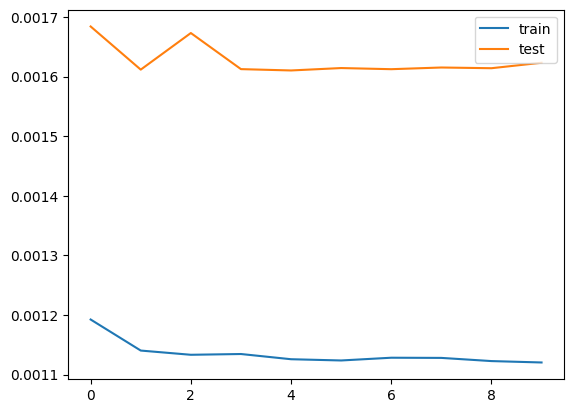

In [ ]:
# plot history

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [19]:
from lwhf.data.biqquery import BigQueryData

PROJECT = "le-wagon-hedge-fund"
DATASET = "data_alpaca_20240604"
TABLE = "SP500_Historical_Weekly"

data = BigQueryData(PROJECT, DATASET, TABLE)

In [20]:
data.get_data(start_date='2018-01-04', end_date='2020-01-01')

Querying data from le-wagon-hedge-fund.data_alpaca_20240604.SP500_Historical_Weekly between 2018-01-04 and 2020-01-01


/Users/behnamnajafi/.pyenv/versions/3.10.6/envs/lwhf/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,AAPL,2018-01-08 05:00:00+00:00,174.35,177.36,173.0000,177.09,118768858.0,713765.0,174.937721
1,AAPL,2018-01-15 05:00:00+00:00,177.90,180.10,175.0700,178.46,140770878.0,759300.0,178.169627
2,AAPL,2018-01-22 05:00:00+00:00,177.30,179.44,170.0600,171.51,204970294.0,1238380.0,174.362602
3,AAPL,2018-01-29 05:00:00+00:00,170.16,170.16,160.1000,160.37,278094573.0,1811059.0,166.009440
4,AAPL,2018-02-05 05:00:00+00:00,159.10,163.88,150.2400,156.41,337562706.0,2185596.0,158.854360
...,...,...,...,...,...,...,...,...,...
50544,ZTS,2019-12-02 05:00:00+00:00,120.87,121.92,118.0000,121.72,14352938.0,103100.0,120.384558
50545,ZTS,2019-12-09 05:00:00+00:00,121.49,125.00,120.6305,124.45,9606285.0,88615.0,123.081489
50546,ZTS,2019-12-16 05:00:00+00:00,125.00,133.52,124.3700,132.68,16604525.0,105786.0,129.252094
50547,ZTS,2019-12-23 05:00:00+00:00,132.60,133.48,131.2900,133.25,5021308.0,45086.0,132.808859


In [21]:
data.get_prices()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-08 05:00:00+00:00,71.73,58.470,115.94,177.09,100.34,99.00,58.84,160.11,195.05,92.02,...,35.49,74.66,87.52,65.79,32.77,70.46,83.62,122.10,53.28,75.39
2018-01-15 05:00:00+00:00,73.07,58.060,117.02,178.46,104.64,100.06,59.31,161.75,195.73,96.14,...,35.45,75.71,87.15,61.95,31.80,71.91,83.81,123.48,53.73,76.62
2018-01-22 05:00:00+00:00,74.82,53.070,123.64,171.51,123.21,105.48,63.42,162.55,201.30,93.84,...,36.67,71.94,89.00,62.84,32.83,74.41,86.20,126.23,54.02,80.09
2018-01-29 05:00:00+00:00,71.25,52.100,113.93,160.37,115.17,96.02,61.69,156.90,195.64,89.11,...,38.25,70.64,84.53,60.06,31.63,75.66,82.63,125.79,54.16,76.78
2018-02-05 05:00:00+00:00,66.98,48.360,109.14,156.41,111.30,89.19,57.17,153.84,187.99,83.93,...,41.86,65.38,75.78,57.18,29.61,70.82,79.31,116.39,51.64,72.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-02 05:00:00+00:00,82.21,27.725,154.62,270.71,86.98,88.24,85.48,202.55,306.23,115.89,...,57.59,91.86,69.51,58.05,37.77,75.32,98.77,148.53,49.71,121.72
2019-12-09 05:00:00+00:00,83.71,27.480,155.21,275.15,87.84,84.85,86.35,206.66,317.94,118.77,...,57.59,96.23,69.23,56.38,36.84,77.72,100.11,148.07,51.15,124.45
2019-12-16 05:00:00+00:00,85.19,29.040,158.12,279.44,89.29,85.67,86.66,211.10,327.61,119.82,...,57.59,97.74,69.94,56.85,37.35,78.61,100.59,150.32,51.63,132.68


In [22]:
data.get_returns()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-15 05:00:00+00:00,0.018681,-0.007012,0.009315,0.007736,0.042854,0.010707,0.007988,0.010243,0.003486,0.044773,...,-0.001127,0.014064,-0.004228,-0.058368,-0.029600,0.020579,0.002272,0.011302,0.008446,0.016315
2018-01-22 05:00:00+00:00,0.023950,-0.085946,0.056572,-0.038944,0.177466,0.054167,0.069297,0.004946,0.028458,-0.023923,...,0.034415,-0.049795,0.021228,0.014366,0.032390,0.034766,0.028517,0.022271,0.005397,0.045288
2018-01-29 05:00:00+00:00,-0.047715,-0.018278,-0.078534,-0.064952,-0.065254,-0.089685,-0.027278,-0.034759,-0.028117,-0.050405,...,0.043087,-0.018071,-0.050225,-0.044239,-0.036552,0.016799,-0.041415,-0.003486,0.002592,-0.041329
2018-02-05 05:00:00+00:00,-0.059930,-0.071785,-0.042043,-0.024693,-0.033603,-0.071131,-0.073270,-0.019503,-0.039102,-0.058130,...,0.094379,-0.074462,-0.103514,-0.047952,-0.063863,-0.063970,-0.040179,-0.074728,-0.046529,-0.057697
2018-02-12 05:00:00+00:00,0.074500,0.066584,-0.014385,0.102423,0.065588,0.114475,0.052475,0.057332,0.072185,0.025736,...,0.046345,0.026155,0.010029,0.021861,0.031746,0.062271,-0.013365,0.035140,0.066421,0.102004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-02 05:00:00+00:00,0.017828,-0.035317,-0.015661,0.012947,-0.008549,0.003754,0.000351,0.006910,-0.010661,0.026029,...,0.000000,-0.009916,0.020255,0.026707,-0.029797,-0.028254,-0.018874,0.022371,-0.001406,0.009957
2019-12-09 05:00:00+00:00,0.018246,-0.008837,0.003816,0.016401,0.009887,-0.038418,0.010178,0.020291,0.038239,0.024851,...,0.000000,0.047572,-0.004028,-0.028768,-0.024623,0.031864,0.013567,-0.003097,0.028968,0.022429
2019-12-16 05:00:00+00:00,0.017680,0.056769,0.018749,0.015591,0.016507,0.009664,0.003590,0.021485,0.030415,0.008841,...,0.000000,0.015692,0.010256,0.008336,0.013844,0.011451,0.004795,0.015196,0.009384,0.066131


In [23]:
returns = data.get_returns()
returns.index

DatetimeIndex(['2018-01-15 05:00:00+00:00', '2018-01-22 05:00:00+00:00',
               '2018-01-29 05:00:00+00:00', '2018-02-05 05:00:00+00:00',
               '2018-02-12 05:00:00+00:00', '2018-02-19 05:00:00+00:00',
               '2018-02-26 05:00:00+00:00', '2018-03-05 05:00:00+00:00',
               '2018-03-12 04:00:00+00:00', '2018-03-19 04:00:00+00:00',
               ...
               '2019-10-28 04:00:00+00:00', '2019-11-04 05:00:00+00:00',
               '2019-11-11 05:00:00+00:00', '2019-11-18 05:00:00+00:00',
               '2019-11-25 05:00:00+00:00', '2019-12-02 05:00:00+00:00',
               '2019-12-09 05:00:00+00:00', '2019-12-16 05:00:00+00:00',
               '2019-12-23 05:00:00+00:00', '2019-12-30 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', length=103, freq=None)

In [24]:
X, y = data.get_Xy(based_on='returns')

Created X and y with shapes (469, 102, 1) and (469,)


In [25]:
as_of_date = '2020-01-01'

In [4]:
df = data.get_data('2016-01-04', as_of_date)

NameError: name 'data' is not defined

In [26]:
import datetime

n_periods = 3

as_of = datetime.datetime.strptime(as_of_date, '%Y-%m-%d').date()
starting_point = as_of - datetime.timedelta(days=7 * n_periods)

In [6]:
df['timestamp'].dt.date < starting_point

NameError: name 'df' is not defined

In [8]:
df['timestamp'].dt.date

NameError: name 'df' is not defined

In [ ]:
df['clean_date'] = df['timestamp']
df['clean_date'] = df['clean_date'].apply(lambda x: f'{x.year}-{x.month:02d}-{x.day:02d}')
df['clean_date']

0         2016-01-04
1         2016-01-11
2         2016-01-18
3         2016-01-25
4         2016-02-01
             ...    
102498    2019-12-02
102499    2019-12-09
102500    2019-12-16
102501    2019-12-23
102502    2019-12-30
Name: clean_date, Length: 102503, dtype: object

# NEW

In [1]:
from lwhf.data.biqquery import BigQueryData

PROJECT = "le-wagon-hedge-fund"
DATASET = "data_alpaca_20240604"
TABLE = "SP500_Historical_Weekly"

data = BigQueryData(PROJECT, DATASET, TABLE)

In [2]:
import datetime

as_of_date = '2024-05-27'
n_periods = 3

In [3]:
from lwhf.portfolio.backtest import BackTester

backtester = BackTester(as_of_date, 3)

In [4]:
backtester.get_all_data()


✅ Found le-wagon-hedge-fund-data_alpaca_20240604-SP500_Historical_Weekly-2016-01-04-2024-05-27.csv in the local cache.


In [5]:
backtester.bq.returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 438 entries, 2016-01-11 05:00:00+00:00 to 2024-05-27 04:00:00+00:00
Columns: 421 entries, A to ZTS
dtypes: float64(421)
memory usage: 1.4 MB


In [6]:
from lwhf.portfolio.backtest import get_Xy
as_of = datetime.datetime.strptime(backtester.as_of_date, '%Y-%m-%d').date()
starting_point = as_of - datetime.timedelta(days=7 * backtester.n_periods)
returns_df = backtester.bq.returns
train_df = returns_df[returns_df.index.date < starting_point]
train_X, train_y = get_Xy(train_df)

In [7]:
print(starting_point)
train_df.shape

2024-05-06


(434, 421)

In [8]:
train_X.shape, train_y.shape

((421, 433, 1), (421,))

In [9]:
backtester.train_model()

Epoch 1/10


2024-06-13 10:00:57.931039: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [12]:
market_returns, portfolio_returns, final_weights = backtester.backtest()
print(market_returns, portfolio_returns, final_weights)


----- Predicting for week 2024-05-06 to 2024-05-13
14/14 [==============================] - 0s 9ms/step
----- Predicting for week 2024-05-13 to 2024-05-20
14/14 [==============================] - 0s 9ms/step
----- Predicting for week 2024-05-20 to 2024-05-27
14/14 [==============================] - 0s 9ms/step
[0.01034749266333977, -0.01639400969687683, 0.003952378767844436] [0.009583147234413707, -0.042586923806796656, 0.03546325304607022]            weights
A     2.961740e-12
AAL   2.411030e-12
AAP   5.607330e-12
AAPL  4.611581e-12
ABBV  2.795484e-11
...            ...
XYL   2.486399e-12
YUM   8.480670e-12
ZBH   7.224847e-12
ZION  2.717746e-12
ZTS   5.298930e-12

[421 rows x 1 columns]


In [15]:
final_weights.to_dict()['weights']

{'A': 2.961740232849115e-12,
 'AAL': 2.411029736051756e-12,
 'AAP': 5.607330197452023e-12,
 'AAPL': 4.611580841654383e-12,
 'ABBV': 2.7954837899650964e-11,
 'ABT': 2.4541495078089627e-11,
 'ACN': 1.3497639777222997e-11,
 'ADBE': 1.070249532589696e-11,
 'ADI': 3.437332739343709e-12,
 'ADM': 4.886279314277753e-12,
 'ADP': 7.999250838516472e-12,
 'ADSK': 9.706160867034578e-12,
 'AEE': 1.589331139046342e-11,
 'AEP': 3.9237985819571874e-12,
 'AES': 1.1454586978346961e-12,
 'AFL': 3.710648444016008e-12,
 'AIG': 2.816665018227425e-12,
 'AIV': 4.966037267104891e-12,
 'AIZ': 1.0561283797900022e-11,
 'AJG': 4.5955352075016316e-12,
 'AKAM': 0.11169746878505066,
 'ALB': 2.498547312375031e-12,
 'ALGN': 5.519584917578723e-12,
 'ALK': 2.9627270997967113e-12,
 'ALL': 6.220330558035288e-12,
 'ALLE': 5.94384202739348e-12,
 'AMAT': 3.005603027562869e-12,
 'AMD': 6.7050847917262696e-12,
 'AME': 9.30295919914757e-12,
 'AMG': 5.439470863357776e-12,
 'AMGN': 2.7474162668523747e-12,
 'AMP': 3.187864684990605e

In [ ]:
import pandas as pd
import numpy as np


ticker_names = list(backtester.bq.returns.columns)
num_tickers = len(ticker_names)
uniform_weights = np.full(num_tickers, 1/num_tickers)
clean_weights = pd.DataFrame(data={'weights': uniform_weights}, index=ticker_names)
clean_weights


,weights
A,0.002375
AAL,0.002375
AAP,0.002375
AAPL,0.002375
ABBV,0.002375
...,...
XYL,0.002375
YUM,0.002375
ZBH,0.002375
ZION,0.002375


In [11]:
from lwhf.portfolio.backtest import make_portfolio, estimate_covariance
from lwhf.data.biqquery import get_Xy
import numpy as np
import pandas as pd
import cvxpy
import riskfolio as rp

as_of = datetime.datetime.strptime(backtester.as_of_date, '%Y-%m-%d').date()
starting_point = as_of - datetime.timedelta(days=7 * backtester.n_periods)
returns_df = backtester.bq.returns

port_return = 1
weekly_returns = []

# have uniform weights to start with
ticker_names = list(returns_df.columns)
num_tickers = len(ticker_names)
uniform_weights = np.full(num_tickers, 1/num_tickers)
clean_weights = pd.DataFrame(data={'weights': uniform_weights}, index=ticker_names)

while starting_point < as_of:
    one_week_ahead = starting_point + datetime.timedelta(days=7)
    print(f'----- Predicting for week {starting_point} to {one_week_ahead}')

    pred_df = returns_df[returns_df.index.date < starting_point]
    pred_X, _ = get_Xy(pred_df)
    y_pred = backtester.model.predict(pred_X)
    cov_df = estimate_covariance(pred_df, 'pandas')

    print(f' -- shape of pred_df: {pred_df.shape}')
    print(f' -- shape of pred_X: {pred_X.shape}')
    print(f' -- shape of y_pred: {y_pred.shape}')
    print(f' -- shape of cov_df: {cov_df.shape}')

    if np.all(y_pred < 0):
        print(' -- all negative')
        starting_point += datetime.timedelta(days=7)
        weekly_returns.append(0)
        #y_pred[0,0] = abs(y_pred[0,0])
        #y_pred[1,0] = abs(y_pred[1,0])
        continue

    port = rp.Portfolio(returns=pred_df)
    port.mu = y_pred.reshape(-1)  # Custom mean vector.
    port.cov = cov_df  # Custom covariance matrix.
    #display(y_pred)
    #display(cov_df)


    # port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
    # y_pred_df = pd.DataFrame(y_pred.T)
    # y_pred_df.columns = pred_df.columns
    # display(port.mu)

    # port.mu = y_pred_df  # Custom mean vector.
    # display(port.mu)

    clean_weights = port.optimization(model='Classic', rm='MV', obj='Sharpe', rf=0, l=0)
    print(clean_weights)


    prices_df = backtester.bq.prices
    print(f' -- shape of prices_df: {prices_df.shape}')
    week_df = prices_df[prices_df.index.date >= starting_point]
    week_df = week_df[week_df.index.date <= one_week_ahead]
    #display(week_df)
    print(f' -- shape of week_df: {week_df.shape}')
    ret = week_df.iloc[-1] / week_df.iloc[0] - 1
    weekly_return = (clean_weights.weights * ret).sum()

    print(f' -- weekly return: {weekly_return}')
    weekly_returns.append(weekly_return)
    port_return *= (1+weekly_return)
    starting_point += datetime.timedelta(days=7)


port_return -= 1

port_return, weekly_returns, clean_weights

----- Predicting for week 2024-05-06 to 2024-05-13
14/14 [==============================] - 0s 9ms/step
 -- shape of pred_df: (434, 421)
 -- shape of pred_X: (421, 433, 1)
 -- shape of y_pred: (421, 1)
 -- shape of cov_df: (421, 421)
           weights
A     1.488100e-11
AAL   3.424325e-12
AAP   2.117709e-12
AAPL  6.336621e-12
ABBV  4.361205e-12
...            ...
XYL   4.553143e-12
YUM   6.318749e-12
ZBH   3.284564e-12
ZION  1.316763e-11
ZTS   6.238193e-12

[421 rows x 1 columns]
 -- shape of prices_df: (439, 421)
 -- shape of week_df: (2, 421)
 -- weekly return: 0.006223680029957318
----- Predicting for week 2024-05-13 to 2024-05-20
14/14 [==============================] - 0s 9ms/step
 -- shape of pred_df: (435, 421)
 -- shape of pred_X: (421, 434, 1)
 -- shape of y_pred: (421, 1)
 -- shape of cov_df: (421, 421)
           weights
A     1.843021e-10
AAL   3.979106e-11
AAP   3.078502e-11
AAPL  1.026129e-11
ABBV  3.118276e-10
...            ...
XYL   1.275073e-11
YUM   3.158106e-11
ZBH

(-0.019482277810584203,
 [0.006223680029957318, -0.00975088910838891, -0.01595161504605222],
            weights
 A     1.722494e-12
 AAL   6.262243e-12
 AAP   3.960616e-12
 AAPL  6.490965e-12
 ABBV  1.663353e-11
 ...            ...
 XYL   1.292432e-12
 YUM   1.200317e-11
 ZBH   9.229794e-12
 ZION  3.230249e-12
 ZTS   1.148491e-11
 
 [421 rows x 1 columns])

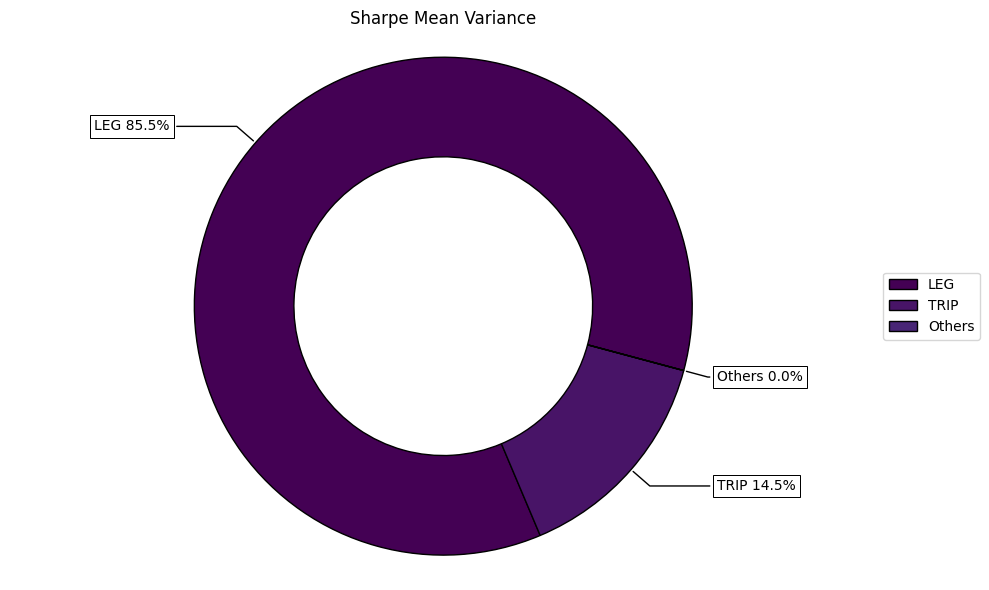

In [ ]:
import matplotlib.pyplot as plt
import riskfolio as rp

cmap = plt.get_cmap("viridis")
ax = rp.plot_pie( w= clean_weights, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = 'viridis',
                        height=6, width=10, ax=None)

In [ ]:
clean_weights[clean_weights.weights > 0.01]

,weights
LEG,0.855318
TRIP,0.144682


In [2]:
import pandas as pd
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from lwhf.ml_logic.backtesting import get_data, features_from_data, initialize_model_LSTM, fitting_model, predicting, making_portfolio, portfolio_returns, backtesting
from lwhf.portfolio.backtest import BackTester, get_total_return
import time, os, json
from lwhf.params import QUERIED_CACHE_LOCAL

def clear_api_cache():
    backtest_api_cache_folder = 'backtest_api_cache'
    full_path = os.path.join(QUERIED_CACHE_LOCAL, backtest_api_cache_folder)
    if os.path.exists(full_path):
        for file in os.listdir(full_path):
            os.remove(os.path.join(full_path, file))
        return {'message': 'Cache cleared'}
    return {'message': 'Cache was already empty'}


def clear_data_cache():
    full_path = QUERIED_CACHE_LOCAL
    if os.path.exists(full_path):
        for file in os.listdir(full_path):
            os.remove(os.path.join(full_path, file))
        return {'message': 'Cache cleared'}


def final_backtest(as_of_date: str, n_periods:int):

    backtest_api_cache_folder = 'backtest_api_cache'
    full_path = os.path.join(QUERIED_CACHE_LOCAL, backtest_api_cache_folder)
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    filename = f'{as_of_date}-{n_periods}.json'
    json_full_path = os.path.join(full_path, filename)
    if os.path.exists(json_full_path):
        print(f'✅ Found {filename} in the local cache.')
        # read the json file as a dictionary
        with open(json_full_path, 'r') as file:
            result = json.load(file)
        return result


    # time.sleep(15)
    print('I start now')
    bt = BackTester(as_of_date, n_periods)
    print('Initialized the class')
    bt.get_all_data()
    print('Got the data')
    bt.train_model()
    print('trained the model, starting backtesting')
    market_returns, portfolio_returns, weekly_weights = bt.backtest()
    total_portfolio_return = get_total_return(portfolio_returns)
    total_market_return = get_total_return(market_returns)
    weekly_weights = [week_df.to_dict()['weights'] for week_df in weekly_weights]
    final_weights = weekly_weights[-1]

    result = {
        'market_returns': market_returns,
        'total_market_return': total_market_return,
        'portfolio_returns': portfolio_returns,
        'total_portfolio_return': total_portfolio_return,
        'weekly_weights': weekly_weights,
        'final_weights': final_weights
    }
    # save the file as a json to full_path
    with open(json_full_path, 'w') as f:
        json.dump(result, f)

    return result

In [3]:
result = final_backtest('2024-05-27', 3)

I start now
Initialized the class
✅ Found le-wagon-hedge-fund-data_alpaca_20240604-SP500_Historical_Weekly-2016-01-04-2024-05-27.csv in the local cache.
Got the data
Epoch 1/10


2024-06-13 12:19:06.188317: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
trained the model, starting backtesting
----- Predicting for week 2024-05-06 to 2024-05-13
14/14 [==============================] - 0s 9ms/step
 -- all returns negative
----- Predicting for week 2024-05-13 to 2024-05-20
14/14 [==============================] - 0s 9ms/step
 -- all returns negative
----- Predicting for week 2024-05-20 to 2024-05-27
14/14 [==============================] - 0s 15ms/step
 -- all returns negative


In [6]:
result['weekly_weights']

[           weights
 A     1.913006e-12
 AAL   1.475626e-12
 AAP   1.540626e-12
 AAPL  2.231907e-12
 ABBV  4.676064e-12
 ...            ...
 XYL   1.700656e-12
 YUM   1.902456e-12
 ZBH   2.614365e-12
 ZION  1.582650e-12
 ZTS   2.445671e-12
 
 [421 rows x 1 columns],
            weights
 A     2.674562e-13
 AAL   1.627414e-13
 AAP   1.946492e-13
 AAPL  2.703896e-13
 ABBV  3.368781e-13
 ...            ...
 XYL   2.247889e-13
 YUM   2.633337e-13
 ZBH   2.572955e-13
 ZION  1.898037e-13
 ZTS   3.232739e-13
 
 [421 rows x 1 columns],
            weights
 A     6.658808e-13
 AAL   3.763752e-13
 AAP   5.100845e-13
 AAPL  6.732302e-13
 ABBV  1.113145e-12
 ...            ...
 XYL   5.599280e-13
 YUM   6.272909e-13
 ZBH   6.611709e-13
 ZION  4.686097e-13
 ZTS   7.527466e-13
 
 [421 rows x 1 columns]]